In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from typing_extensions import TypedDict
from typing import Annotated

In [6]:
class State(TypedDict):
    # messages have the type of "list". The 'add_messages' function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [4]:
@tool
def get_stock_price(symbol: str) -> float:
    ''' Retrun the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''

    return {
        'MARUTI': 14090.00,
        'HEROMOTOCO': 4990.00,
        'NESTLEIND': 1146.40,
        'BAJFINANCE': 905.05,
        'BAJAJ-AUTO': 8592.00
    }.get(symbol, 0.0)

tools = [get_stock_price]

llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)


In [10]:
def chatbot_agent(state: State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

builder = StateGraph(State)

builder.add_node("chatbot_agent_node", chatbot_agent)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot_agent_node")
builder.add_conditional_edges("chatbot_agent_node", tools_condition)

graph = builder.compile()

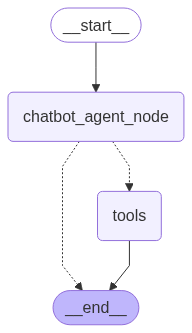

In [12]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
msg = "what is the price MARUTI stock right now ?"

state = graph.invoke({"messages":[{"role":"user","content":msg}]})
print(state["messages"][-1].content)

14090.0


In [15]:
msg1 = "what is the price HEROMOTOCO stock right now ?"

state = graph.invoke({"messages":[{"role":"user","content":msg1}]})
print(state["messages"][-1].content)

4990.0


In [16]:
msg2 = "I want to buy 20 MARUTI stocks using current price. Then 15 HEROMOTOCO. What will be the total cost?"

state = graph.invoke({"messages":[{"role":"user","content":msg2}]})
print(state["messages"][-1].content)

4990.0


In [17]:
print("done but the reasoning can't performed by agentbot")

done but the reasoning can't performed by agentbot
